In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

sns.set_theme()

In [72]:
import os

PLOT_DIR = "example-plots"

if not(os.path.exists(PLOT_DIR)):
    os.mkdir(PLOT_DIR)

In [73]:
THESIS_DIR = os.path.join(os.environ["HOME"], "Documents", "Studie", "Thesis", "Report", "thesis", "src")

if not(os.path.exists(THESIS_DIR)):
    raise Error("Set the correct thesis root dir to save results to!")

THESIS_FIGURE_DIR = os.path.join(THESIS_DIR, "fig")
THESIS_TABLE_DIR = os.path.join(THESIS_DIR, "tab")

os.makedirs(THESIS_FIGURE_DIR, exist_ok=True)
os.makedirs(THESIS_TABLE_DIR, exist_ok=True)

In [113]:
# Load data
results_files = [
    "chocopy-results4.csv"
#     "20211014-124146 -p optimisationLevel=4 -f 2 -wi 2 -i 3 run.csv",
#     "20211013-114213_results-compilespace.csv"
#     "20211013-114213_results-compilespace.csv"
#     "20211013-124531-benchnullary.csv"
#     "20211012-102647.csv"
#     "20211007-135249.csv",
#     "20211007-084741.csv", # benchsym switch backend
#     "20211006-143434.csv", # more problem swtich backend
#     "20210915-111700.csv",
#     "results-compilespace.csv",
]

df_raw = pd.concat(map(lambda f: pd.read_csv(f"results/{f}"), results_files), ignore_index=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Benchmark                    28 non-null     object 
 1   Mode                         28 non-null     object 
 2   Threads                      28 non-null     int64  
 3   Samples                      28 non-null     int64  
 4   Score                        28 non-null     float64
 5   Score Error (99.9%)          28 non-null     float64
 6   Unit                         28 non-null     object 
 7   Param: metaborgVersion       28 non-null     object 
 8   Param: optimisationLevel     28 non-null     int64  
 9   Param: problemSize           28 non-null     int64  
 10  Param: sharedConstructors    28 non-null     object 
 11  Param: switchImplementation  14 non-null     object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.8+ KB


In [114]:
for col in ["Score", "Score Error (99.9%)"]:
    if col in df_raw and df_raw[col].dtype == object:
        df_raw[col] = df_raw[col].map(lambda s: s.replace(',', '.'), na_action="ignore").astype(float)

# df_raw

In [115]:
df_raw["Param: optimisationLevel"] = df_raw["Param: optimisationLevel"].astype("string")

In [116]:
df = df_raw[df_raw.Benchmark.str.endswith("jfr") == False].copy()
df

,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Param: metaborgVersion,Param: optimisationLevel,Param: problemSize,Param: sharedConstructors,Param: switchImplementation
0,benchmark.chocopy.compilation.CallMutual.compi...,ss,1,3,0.298973,0.346669,s/op,2.6.0-SNAPSHOT,2,-1,on,NaN
1,benchmark.chocopy.compilation.CallMutual.compi...,ss,1,3,0.282389,1.079948,s/op,2.6.0-SNAPSHOT,4,-1,on,hash-switch
2,benchmark.chocopy.compilation.Exp.compileChocoPy,ss,1,3,0.325631,2.348324,s/op,2.6.0-SNAPSHOT,2,-1,on,NaN
3,benchmark.chocopy.compilation.Exp.compileChocoPy,ss,1,3,0.283008,1.436985,s/op,2.6.0-SNAPSHOT,4,-1,on,hash-switch
4,benchmark.chocopy.compilation.GoingUpMultipleF...,ss,1,3,0.371756,1.379773,s/op,2.6.0-SNAPSHOT,2,-1,on,NaN
5,benchmark.chocopy.compilation.GoingUpMultipleF...,ss,1,3,0.282552,0.969774,s/op,2.6.0-SNAPSHOT,4,-1,on,hash-switch
6,benchmark.chocopy.compilation.Prime.compileCho...,ss,1,3,0.908309,16.713059,s/op,2.6.0-SNAPSHOT,2,-1,on,NaN
7,benchmark.chocopy.compilation.Prime.compileCho...,ss,1,3,0.188773,0.753105,s/op,2.6.0-SNAPSHOT,4,-1,on,hash-switch
8,benchmark.chocopy.compilation.Sieve.compileCho...,ss,1,3,0.505013,1.113755,s/op,2.6.0-SNAPSHOT,2,-1,on,NaN
9,benchmark.chocopy.compilation.Sieve.compileCho...,ss,1,3,0.451772,2.191974,s/op,2.6.0-SNAPSHOT,4,-1,on,hash-switch


In [119]:
df["Stage"] = df["Benchmark"].str.rpartition('.')[2]
df["Problem"] = df["Benchmark"].str.split('.').map(lambda l: l[-2])
df

,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Param: metaborgVersion,Param: optimisationLevel,Param: problemSize,Param: sharedConstructors,Param: switchImplementation,Stage,Problem
0,benchmark.chocopy.compilation.CallMutual.compi...,ss,1,3,0.298973,0.346669,s/op,2.6.0-SNAPSHOT,2,-1,on,NaN,compileChocoPy,CallMutual
1,benchmark.chocopy.compilation.CallMutual.compi...,ss,1,3,0.282389,1.079948,s/op,2.6.0-SNAPSHOT,4,-1,on,hash-switch,compileChocoPy,CallMutual
2,benchmark.chocopy.compilation.Exp.compileChocoPy,ss,1,3,0.325631,2.348324,s/op,2.6.0-SNAPSHOT,2,-1,on,NaN,compileChocoPy,Exp
3,benchmark.chocopy.compilation.Exp.compileChocoPy,ss,1,3,0.283008,1.436985,s/op,2.6.0-SNAPSHOT,4,-1,on,hash-switch,compileChocoPy,Exp
4,benchmark.chocopy.compilation.GoingUpMultipleF...,ss,1,3,0.371756,1.379773,s/op,2.6.0-SNAPSHOT,2,-1,on,NaN,compileChocoPy,GoingUpMultipleFrames
5,benchmark.chocopy.compilation.GoingUpMultipleF...,ss,1,3,0.282552,0.969774,s/op,2.6.0-SNAPSHOT,4,-1,on,hash-switch,compileChocoPy,GoingUpMultipleFrames
6,benchmark.chocopy.compilation.Prime.compileCho...,ss,1,3,0.908309,16.713059,s/op,2.6.0-SNAPSHOT,2,-1,on,NaN,compileChocoPy,Prime
7,benchmark.chocopy.compilation.Prime.compileCho...,ss,1,3,0.188773,0.753105,s/op,2.6.0-SNAPSHOT,4,-1,on,hash-switch,compileChocoPy,Prime
8,benchmark.chocopy.compilation.Sieve.compileCho...,ss,1,3,0.505013,1.113755,s/op,2.6.0-SNAPSHOT,2,-1,on,NaN,compileChocoPy,Sieve
9,benchmark.chocopy.compilation.Sieve.compileCho...,ss,1,3,0.451772,2.191974,s/op,2.6.0-SNAPSHOT,4,-1,on,hash-switch,compileChocoPy,Sieve


In [79]:
program_text = """
module calls

imports libstrategolib

signature

sorts
   S

constructors
   nullary_constructor : S 
   unary_constructor : S -> S 
   nary_constructor : S * S * S -> S 
   nullary_function : S 
   unary_function : S -> S 
   nary_function : S * S * S -> S 
   a : S 
   b : S 
   c : S 
   d : S 
   e : S 
   f : S 

rules
   REC_E: nullary_function() -> nullary_constructor()
   REC_E: unary_function (x) -> unary_constructor (x)
   REC_E: nary_function (x, y, z) -> nary_constructor (x, y, z)
   REC_E: a() -> nullary_constructor()
   REC_E: b() -> unary_constructor (nullary_constructor())
   REC_E: c() -> nary_constructor (nullary_constructor(), nullary_constructor(), nullary_constructor())
   REC_E: d() -> nullary_function()
   REC_E: e() -> unary_function (nullary_function())
   REC_E: f() -> nary_function (nullary_function(), nullary_function(), nullary_function())

strategies
   eval = memo (innermost (REC_E))
   eval-and-print = eval ; debug (!"result = ")
   main = 
      (<eval-and-print> nullary_constructor()) ;
      (<eval-and-print> unary_constructor (nullary_constructor())) ;
      (<eval-and-print> nary_constructor (nullary_constructor(), nullary_constructor(), nullary_constructor())) ;
      (<eval-and-print> nullary_function()) ;
      (<eval-and-print> unary_function (nullary_function())) ;
      (<eval-and-print> nary_function (nullary_function(), nullary_function(), nullary_function())) ;
      <exit> 0

"""

In [80]:
df["Param: problemSize"].astype("str").mask(df["Param: problemSize"]==-1, "")

0    
1    
2    
3    
4    
5    
6    
7    
Name: Param: problemSize, dtype: object

In [83]:
import re
import os

# Add number of unique constructors to problems
# cons_regex_pat = r"\bconstructors\b\W*(?:\s*(\w*)\s*:.*\s*)*\W*\brules\b"

cons_area_regex = r"^\s*constructors\s*$((?:.*\n)*)^\s*rules\s*$"
cons_area_pat = re.compile(cons_area_regex, re.MULTILINE)

cons_regex = r"\w+\s*:.*\S"
cons_pat = re.compile(cons_regex)

def find_constructors(p):
    cons_areas = cons_area_pat.findall(p)
    cons_groups = list(map(cons_pat.findall, cons_areas))
    conses = set().union(*cons_groups)
    return conses

def count_constructors_in_file(program_name):
    p_program = os.path.join("..", "src", "main", "resources", program_name + ".str2")
    try:
        with open(p_program, 'r') as f_program:
            contents = f_program.read()
            conses = find_constructors(contents)
            return len(conses)
    except:
        return np.nan

df["Number of constructors"] = (df["Problem"].str.lower() + df["Param: problemSize"].astype("str").mask(df["Param: problemSize"]==-1, "")).map(count_constructors_in_file)

In [84]:
## Plot-specific settings
configs = [
    {
        "problems": {"Benchexpr", "Benchsym", "Benchtree", "Bubblesort", "Factorial", "Fibonacci", "Hanoi", "Mergesort", "Quicksort", "Sieve"},
        "stages": {"run"},
        "settings": {"yscale": "log"}
    },
    {
        # Apply to all problems
        "stages": {"compileStratego", "compileJava", "Java space", "Class space"},
        "settings": {"ylim": (0, None)}
    },
    {
        "stages": {"Java space", "Class space"},
        "settings": {"ylabel": "Size (bytes)"}
    }
]

In [85]:
from pandas.core.common import flatten

def configure_grid(g: sns.FacetGrid, problem=None):
    ## Global settings
    g.set_ylabels("Time (s)")
    g.set_xlabels("Input size")

    for ax in flatten(g.axes):
        ax.get_xaxis().set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

    # Specific settings
    try:
        for (row_val, col_val), ax in g.axes_dict.items():
            for config in configs:
                if "problems" not in config or row_val in config["problems"]:
                    if "stages" not in config or col_val in config["stages"]:
                        ax.set(**config["settings"])
    except (ValueError):
        for col_val, ax in g.axes_dict.items():
            for config in configs:
                if "problems" not in config or problem in config["problems"]:
                    if "stages" not in config or col_val in config["stages"]:
                        ax.set(**config["settings"])
    finally:
        return g

In [86]:
df_scaledproblem = df[(df["Param: problemSize"] != -1) & (df["Problem"] != "BenchNullary")]

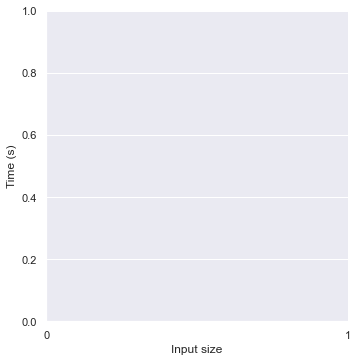

In [87]:
g = configure_grid(sns.relplot(
    data=df_scaledproblem,
    x="Param: problemSize",
    y="Score",
    row="Problem",
    row_order=np.sort(np.unique(df_scaledproblem["Problem"].values)),
    col="Stage",
    col_order=[s for s in ["compileStratego", "Java space", "compileJava", "Class space", "run"] if s in df_scaledproblem["Stage"].values],
    style="Param: switchImplementation",
    hue="Param: optimisationLevel",
    hue_order=["2", "3", "4"],
    kind="line",
#     err_style="band",
    markers=True,
    facet_kws=dict(
        sharex=False, 
        sharey=False,
    ),
))

# TODO Include strj runtime -> with and without fusion

# Save figure to file
plt.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-allstages.png")

In [88]:
# Runtimes for DFA switch backends (per problem)

cols = np.sort(np.unique(df_scaledproblem["Problem"].values))

g = configure_grid(sns.relplot(
    data=df_scaledproblem[df_scaledproblem["Stage"] == "run"],
    x="Param: problemSize",
    y="Score",
    col="Problem",
    col_order=cols,
    col_wrap=min(3, len(cols)),
#     style="Param: switchImplementation",
    hue="Param: switchImplementation",
#     hue_order=["2", "3", "4"],
    kind="line",
#     err_style="band",
    markers=True,
    facet_kws=dict(
        sharex=False, 
        sharey=False,
    ),
))

g.set(yscale="log")

# TODO Include strj runtime -> with and without fusion

# Save figure to file
plt.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-runtime.png")

ZeroDivisionError: division by zero

In [89]:
df_ratios = df[df["Stage"] == "run"].pivot(index=["Param: switchImplementation"], columns=["Benchmark", "Param: problemSize", "Number of constructors", "Problem"], values="Score").T

# df_ratios["Ratio"] = df_ratios["elseif"] / df_ratios["switch"]
df_ratios["Ratio [nested]"] = df_ratios["nested-switch"] / df_ratios["elseif"]
df_ratios["Ratio [hash]"] = df_ratios["hash-switch"] / df_ratios["elseif"]

df_ratios.sort_values("Ratio [hash]")

# df_ratios.columns.to_series().apply(''.join)

# df[df[""]]

KeyError: 'nested-switch'

In [92]:
df_ratios_flat = df_ratios.melt(value_vars=["Ratio [hash]"], value_name="Ratio", ignore_index=False)
# df_ratios_flat.index = df_ratios_flat.index.to_flat_index()
# df_ratios_flat.reset_index()
df_ratios_flat.index

KeyError: "The following 'value_vars' are not present in the DataFrame: ['Ratio [hash]']"

In [93]:
# Runtimes for DFA switch backends (against number of constructors)

g = configure_grid(sns.relplot(
    data=df_ratios,
    x="Number of constructors",
    y="Ratio [hash]",
    style="Problem",
    hue="Problem",
    size="Param: problemSize",
    kind="scatter",
    markers=True,
    facet_kws=dict(
        sharex=False, 
        sharey=False,
    ),
))

# g.set(yscale="log")
g.set_ylabels("Ratio of runtime [hash-switch] over runtime [elseif]")
g.set_xlabels("# of constructors in program")

# TODO Include strj runtime -> with and without fusion

# Save figure to file
plt.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-backend-constructors.png")

ValueError: Could not interpret value `Ratio [hash]` for parameter `y`

In [90]:
# g = sns.boxplot(
#     data=df_ratios,
#     x="Number of constructors",
#     y="Ratio",
#     hue="Problem"
# )

df_ratios.columns#.to_flat_index()
# df_ratios.columns.get_level_values(0) + '_' +  df_ratios.columns.get_level_values(1)

Index([], dtype='object', name='Param: switchImplementation')

In [91]:
for problem in ["Benchexpr", "Bubblesort", "Hanoi"]:
    df_problem = df_scaledproblem[df_scaledproblem["Problem"] == problem]
    
    cols = [s for s in ["compileStratego", "compileJava", "run", "Java space", "Class space"] if s in df_problem["Stage"].values]

    g = configure_grid(sns.relplot(
        data=df_problem,
        x="Param: problemSize",
        y="Score",
#         row="Problem",
#         row_order=np.sort(np.unique(df_problem["Problem"].values)),
        col_wrap=min(3, len(cols)),
        col="Stage",
        col_order=cols,
        style="Param: switchImplementation",
        hue="Param: optimisationLevel",
        hue_order=[l for l in ["2", "3", "4"] if l in df_problem["Param: optimisationLevel"].values],
        kind="line",
    #     err_style="band",
        markers=True,
        facet_kws=dict(
            sharex=False, 
            sharey=False,
        ),
    ), problem)

    # Save figure to file
    plt.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-{problem}.png")

ZeroDivisionError: division by zero

In [120]:
df_unscaledproblem = df[df["Param: problemSize"] == -1]

print(df_unscaledproblem.to_latex(
    columns=["Problem", "Stage", "Samples", "Score", "Score Error (99.9%)", "Param: optimisationLevel", "Param: switchImplementation"]
))

df_unscaledproblem

\begin{tabular}{lllrrrll}
\toprule
{} &                Problem &           Stage &  Samples &     Score &  Score Error (99.9\%) & Param: optimisationLevel & Param: switchImplementation \\
\midrule
0  &             CallMutual &  compileChocoPy &        3 &  0.298973 &             0.346669 &                        2 &                         NaN \\
1  &             CallMutual &  compileChocoPy &        3 &  0.282389 &             1.079948 &                        4 &                 hash-switch \\
2  &                    Exp &  compileChocoPy &        3 &  0.325631 &             2.348324 &                        2 &                         NaN \\
3  &                    Exp &  compileChocoPy &        3 &  0.283008 &             1.436985 &                        4 &                 hash-switch \\
4  &  GoingUpMultipleFrames &  compileChocoPy &        3 &  0.371756 &             1.379773 &                        2 &                         NaN \\
5  &  GoingUpMultipleFrames &  compileChoco

,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Param: metaborgVersion,Param: optimisationLevel,Param: problemSize,Param: sharedConstructors,Param: switchImplementation,Stage,Problem
0,benchmark.chocopy.compilation.CallMutual.compi...,ss,1,3,0.298973,0.346669,s/op,2.6.0-SNAPSHOT,2,-1,on,NaN,compileChocoPy,CallMutual
1,benchmark.chocopy.compilation.CallMutual.compi...,ss,1,3,0.282389,1.079948,s/op,2.6.0-SNAPSHOT,4,-1,on,hash-switch,compileChocoPy,CallMutual
2,benchmark.chocopy.compilation.Exp.compileChocoPy,ss,1,3,0.325631,2.348324,s/op,2.6.0-SNAPSHOT,2,-1,on,NaN,compileChocoPy,Exp
3,benchmark.chocopy.compilation.Exp.compileChocoPy,ss,1,3,0.283008,1.436985,s/op,2.6.0-SNAPSHOT,4,-1,on,hash-switch,compileChocoPy,Exp
4,benchmark.chocopy.compilation.GoingUpMultipleF...,ss,1,3,0.371756,1.379773,s/op,2.6.0-SNAPSHOT,2,-1,on,NaN,compileChocoPy,GoingUpMultipleFrames
5,benchmark.chocopy.compilation.GoingUpMultipleF...,ss,1,3,0.282552,0.969774,s/op,2.6.0-SNAPSHOT,4,-1,on,hash-switch,compileChocoPy,GoingUpMultipleFrames
6,benchmark.chocopy.compilation.Prime.compileCho...,ss,1,3,0.908309,16.713059,s/op,2.6.0-SNAPSHOT,2,-1,on,NaN,compileChocoPy,Prime
7,benchmark.chocopy.compilation.Prime.compileCho...,ss,1,3,0.188773,0.753105,s/op,2.6.0-SNAPSHOT,4,-1,on,hash-switch,compileChocoPy,Prime
8,benchmark.chocopy.compilation.Sieve.compileCho...,ss,1,3,0.505013,1.113755,s/op,2.6.0-SNAPSHOT,2,-1,on,NaN,compileChocoPy,Sieve
9,benchmark.chocopy.compilation.Sieve.compileCho...,ss,1,3,0.451772,2.191974,s/op,2.6.0-SNAPSHOT,4,-1,on,hash-switch,compileChocoPy,Sieve


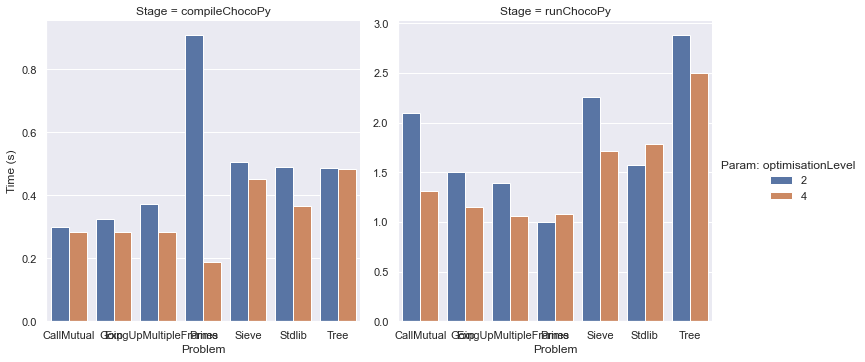

In [121]:
g = sns.catplot(
    data = df_unscaledproblem,
    x = "Problem",
    y = "Score",
    col = "Stage",
    hue = "Param: optimisationLevel",
    kind = "bar",
    sharey=False,
)

g.set_ylabels("Time (s)")

plt.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-unscaled.png")